In [ ]:
!pip install catboost
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import pandas as pd
import kagglehub
import os

# Скачиваем датасет
path = kagglehub.dataset_download("mohithsairamreddy/salary-data")

print("Path to dataset files:", path)

# Формируем путь к файлу Salary_Data.csv
csv_path = os.path.join(path, "Salary_Data.csv")

# Читаем CSV через pandas
data = pd.read_csv(csv_path)

print(data.head())


100%|██████████| 16.6k/16.6k [00:00<00:00, 22.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mohithsairamreddy/salary-data/versions/4
    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


Распределение профессий до объединения:
Job Title
Software Engineer                     518
Data Scientist                        453
Software Engineer Manager             376
Data Analyst                          363
Senior Project Engineer               318
                                     ... 
Junior Research Scientist               1
Senior Product Development Manager      1
Junior Social Media Specialist          1
Senior Software Architect               1
Social Media Man                        1
Name: count, Length: 191, dtype: int64


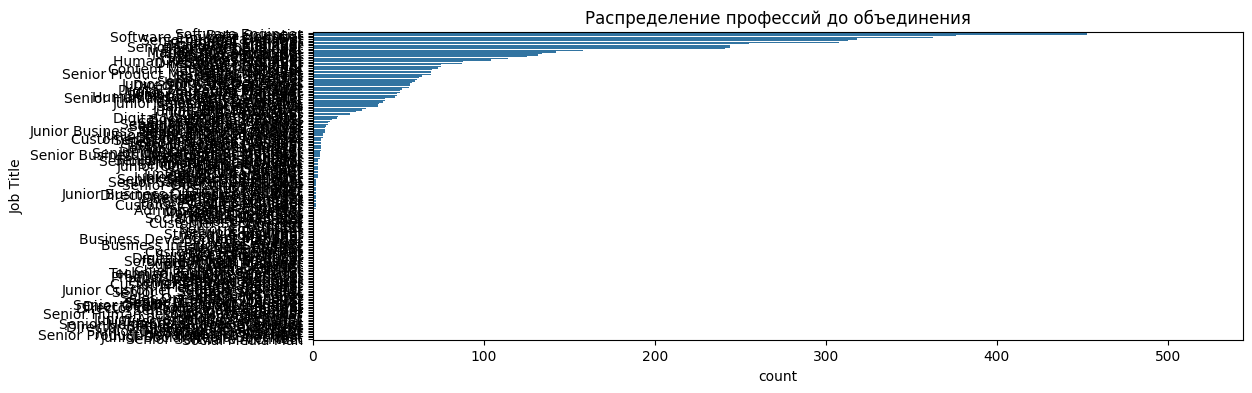


Распределение профессий после объединения по блокам:
Job Category
Tech          1736
Marketing      990
Management     885
Name: count, dtype: int64


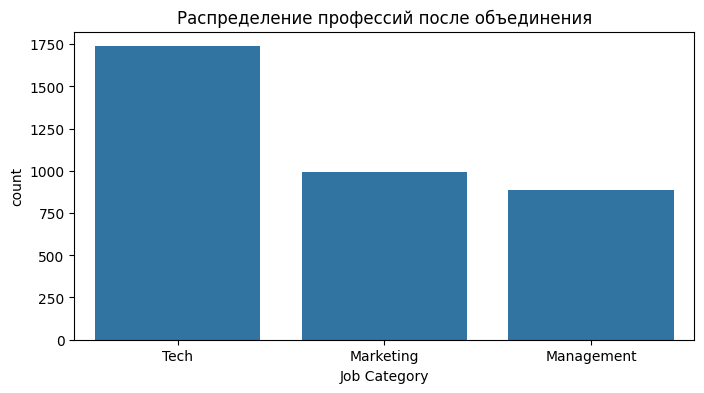

=== CatBoost Classification Report ===
              precision    recall  f1-score   support

  Management       0.94      0.89      0.91       281
   Marketing       0.89      0.92      0.90       288
        Tech       0.94      0.95      0.94       515

    accuracy                           0.93      1084
   macro avg       0.92      0.92      0.92      1084
weighted avg       0.93      0.93      0.93      1084



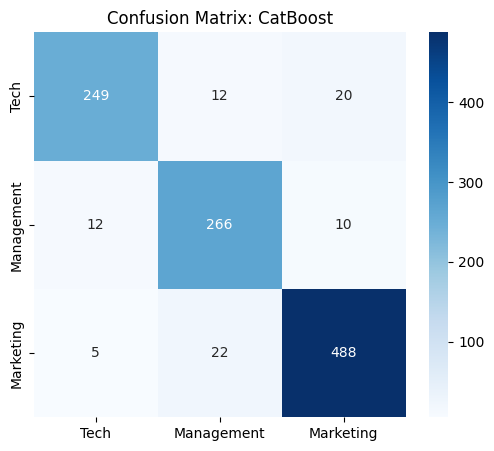

In [ ]:

data = data.dropna(subset=['Job Title'])
data = data.dropna()

print("Распределение профессий до объединения:")
print(data['Job Title'].value_counts())

plt.figure(figsize=(12,4))
sns.countplot(y='Job Title', data=data, order=data['Job Title'].value_counts().index)
plt.title('Распределение профессий до объединения')
plt.show()

job_map = {
    # Tech / IT
    'Software Engineer':'Tech', 'Senior Software Engineer':'Tech', 'Junior Software Developer':'Tech',
    'Front End Developer':'Tech','Data Scientist':'Tech','Data Analyst':'Tech','Machine Learning Engineer':'Tech',
    'Machine Learning Scientist':'Tech','Data Specialist':'Tech','Analytics Engineer':'Tech','Data Science Consultant':'Tech',
    # Management / Director
    'Senior Manager':'Management','Project Manager':'Management','Product Manager':'Management',
    'Director of Data Science':'Management','Research Director':'Management','Operations Manager':'Management',
    'Human Resources Manager':'Management','Marketing Director':'Management','Financial Manager':'Management',
    # Marketing / Sales
    'Marketing Coordinator':'Marketing','Marketing Analyst':'Marketing','Marketing Manager':'Marketing',
    'Digital Marketing Specialist':'Marketing','Sales Associate':'Marketing','Junior Sales Associate':'Marketing',
    'Social Media Manager':'Marketing',
    'Product Designer':'Marketing','Graphic Designer':'Marketing',
    'Research Scientist':'Tech',
    'Receptionist':'Marketing','Customer Service Representative':'Marketing','Delivery Driver':'Marketing','HR Specialist':'Marketing','Financial Analyst':'Marketing'
}

data['Job Category'] = data['Job Title'].map(job_map)


data = data.dropna(subset=['Job Category'])
print("\nРаспределение профессий после объединения по блокам:")
print(data['Job Category'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='Job Category', data=data, order=data['Job Category'].value_counts().index)
plt.title('Распределение профессий после объединения')
plt.show()

X = data[['Age','Gender','Education Level','Years of Experience','Salary']]
y = data['Job Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for col in ['Age','Years of Experience','Salary']:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())

for col in ['Gender','Education Level']:
    X_train[col] = X_train[col].fillna('Unknown')
    X_test[col] = X_test[col].fillna('Unknown')

cat_features = ['Gender','Education Level']

cat_model = CatBoostClassifier(
    iterations=500,      # Optuna: 100-2000
    depth=4,             # Optuna: 3-10
    learning_rate=0.1,   # Optuna: 0.01-0.3
    l2_leaf_reg=3,       # Optuna: 1-10
    verbose=0
)
cat_model.fit(X_train, y_train, cat_features=cat_features)
y_pred_cat = cat_model.predict(X_test)

print("=== CatBoost Classification Report ===")
print(classification_report(y_test, y_pred_cat))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt='d', cmap='Blues',
            xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix: CatBoost')
plt.show()

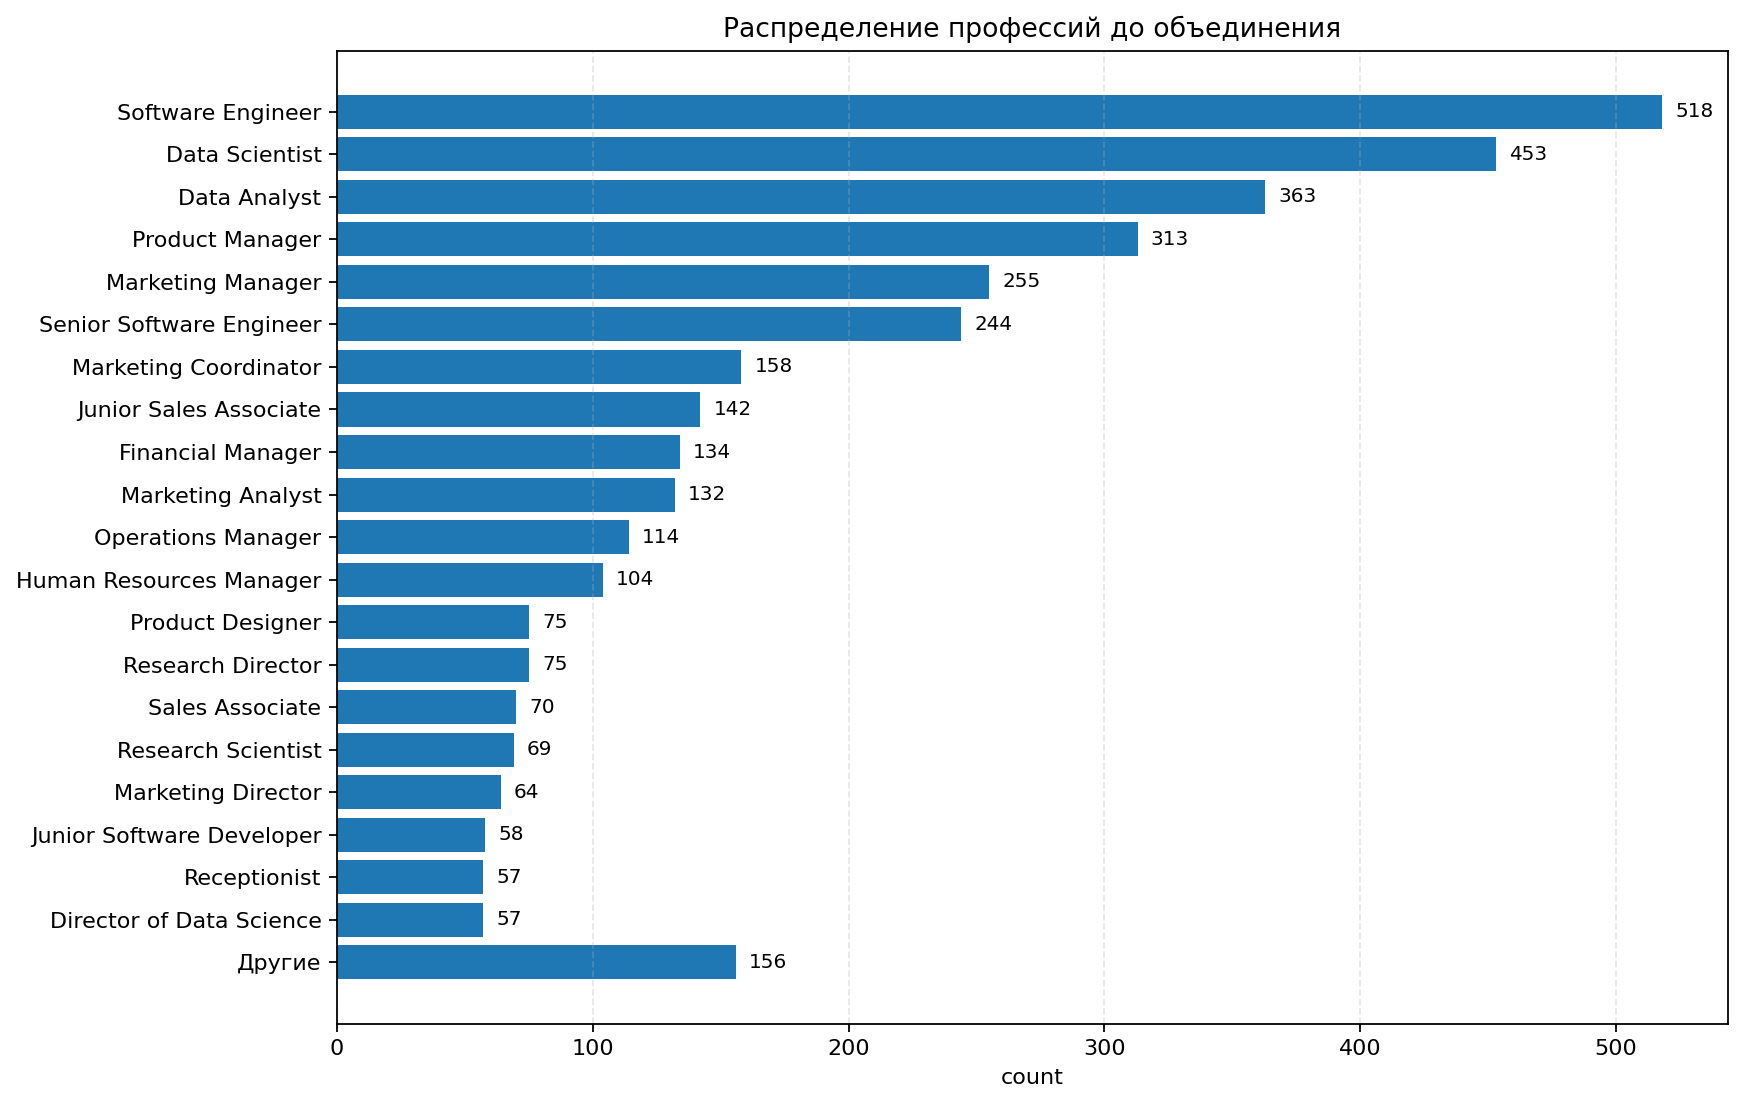

In [ ]:
# --- чистка и стратификация ---
data = data.dropna(subset=['Job Title']).copy()   # .copy() чтобы не ловить SettingWithCopyWarning

# --- 1) ДО объединения: красивый топ-N ---
from textwrap import shorten
import numpy as np
import matplotlib.pyplot as plt

top_n = 20
title_col = 'Job Title'

counts = (data[title_col].str.strip().value_counts())
top = counts.head(top_n)
other = counts.iloc[top_n:].sum()
if other > 0:
    top = pd.concat([top, pd.Series({'Другие': other})])

labels = [shorten(s, width=40, placeholder='…') for s in top.index]
vals = top.values
ypos = np.arange(len(vals))[::-1]

plt.figure(figsize=(11,7), dpi=160)
plt.barh(ypos, vals)
plt.yticks(ypos, labels, fontsize=10)
plt.xlabel('count')
plt.title('Распределение профессий до объединения')
plt.grid(axis='x', linestyle='--', alpha=0.3)
for y, v in zip(ypos, vals):
    plt.text(v + max(vals)*0.01, y, str(v), va='center', fontsize=9)
plt.tight_layout()
plt.show()


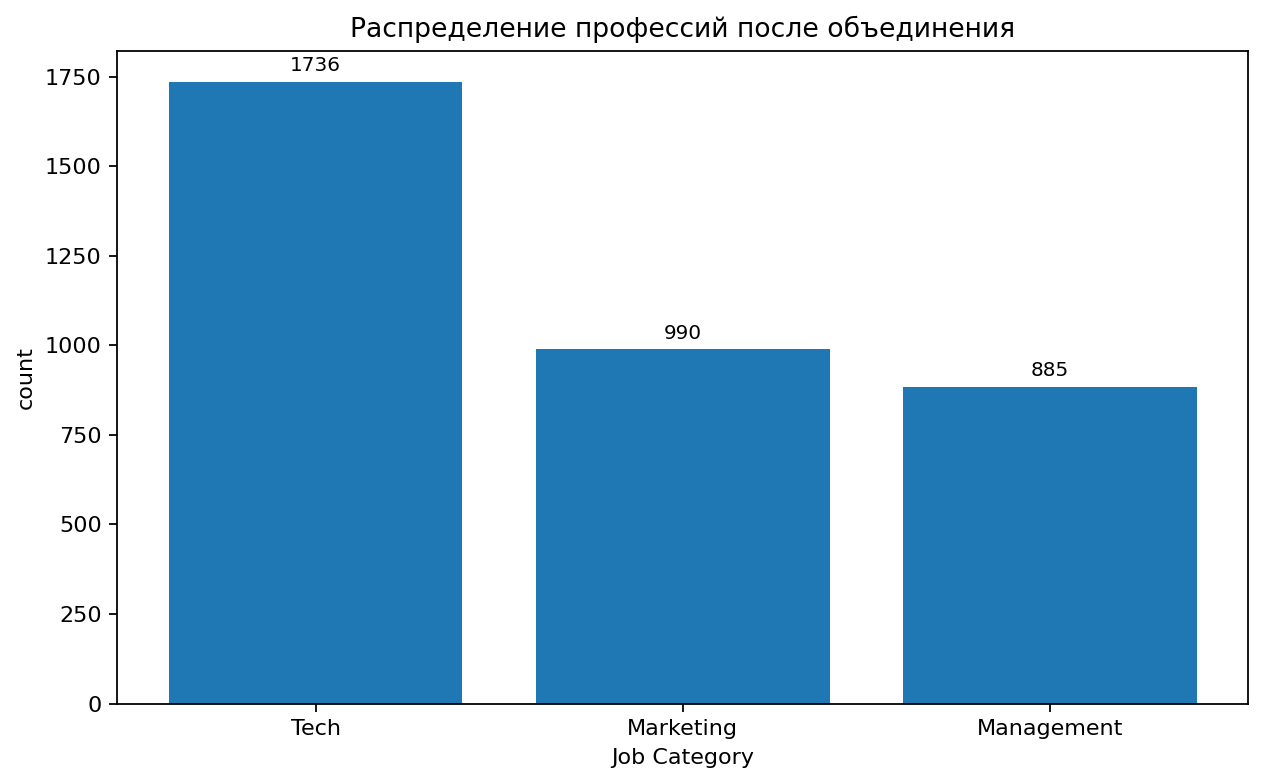

In [ ]:
# --- 2) ПОСЛЕ объединения: аккуратные столбцы ---
data['Job Category'] = data['Job Title'].map(job_map)
data = data.dropna(subset=['Job Category']).copy()

cat_counts = data['Job Category'].value_counts()
plt.figure(figsize=(8,5), dpi=160)
order = cat_counts.index
plt.bar(order, cat_counts.values)
plt.ylabel('count'); plt.xlabel('Job Category')
plt.title('Распределение профессий после объединения')
for x, v in zip(order, cat_counts.values):
    plt.text(x, v + cat_counts.max()*0.01, str(v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
# --- 3) Разбиение и заполнение пропусков (с поправками) ---
X = data[['Age','Gender','Education Level','Years of Experience','Salary']].copy()
y = data['Job Category'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)  # стратификация!

for col in ['Age','Years of Experience','Salary']:
    med = X_train[col].median()
    X_train.loc[:, col] = X_train[col].fillna(med)
    X_test.loc[:, col]  = X_test[col].fillna(med)

for col in ['Gender','Education Level']:
    X_train.loc[:, col] = X_train[col].fillna('Unknown')
    X_test.loc[:, col]  = X_test[col].fillna('Unknown')


In [ ]:
# --- 4) Обучение CatBoost ---
from catboost import CatBoostClassifier
cat_features = ['Gender','Education Level']
cat_model = CatBoostClassifier(
    iterations=500, depth=4, learning_rate=0.1, l2_leaf_reg=3, verbose=0
)
cat_model.fit(X_train, y_train, cat_features=cat_features)

from sklearn.metrics import classification_report, confusion_matrix
y_pred_cat = cat_model.predict(X_test)

print("=== CatBoost Classification Report ===")
print(classification_report(y_test, y_pred_cat))


=== CatBoost Classification Report ===
              precision    recall  f1-score   support

  Management       0.88      0.93      0.91       266
   Marketing       0.91      0.92      0.92       297
        Tech       0.96      0.92      0.94       521

    accuracy                           0.92      1084
   macro avg       0.92      0.93      0.92      1084
weighted avg       0.93      0.92      0.92      1084



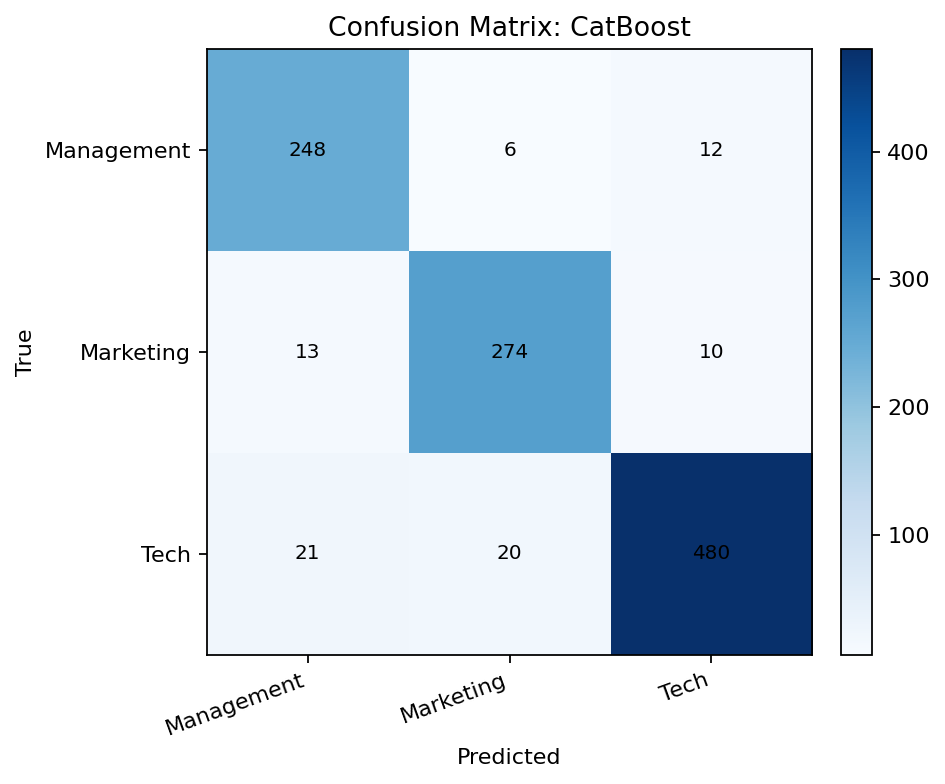

In [ ]:
# --- 5) Матрица ошибок с корректными подписями и красотой ---
import numpy as np
import matplotlib.pyplot as plt

labels = sorted(y.unique())  # единый порядок классов
cm = confusion_matrix(y_test, y_pred_cat, labels=labels)

plt.figure(figsize=(6,5), dpi=160)
im = plt.imshow(cm, cmap='Blues')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(labels)), labels, rotation=20, ha='right')
plt.yticks(np.arange(len(labels)), labels)
plt.title('Confusion Matrix: CatBoost')
plt.xlabel('Predicted'); plt.ylabel('True')

# подписи ячеек
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()



=== Важность признаков ===
            Feature Id  Importances
0               Salary    37.491622
1  Years of Experience    20.140903
2                  Age    19.058807
3      Education Level    18.401417
4               Gender     4.907251


/tmp/ipython-input-4064878592.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


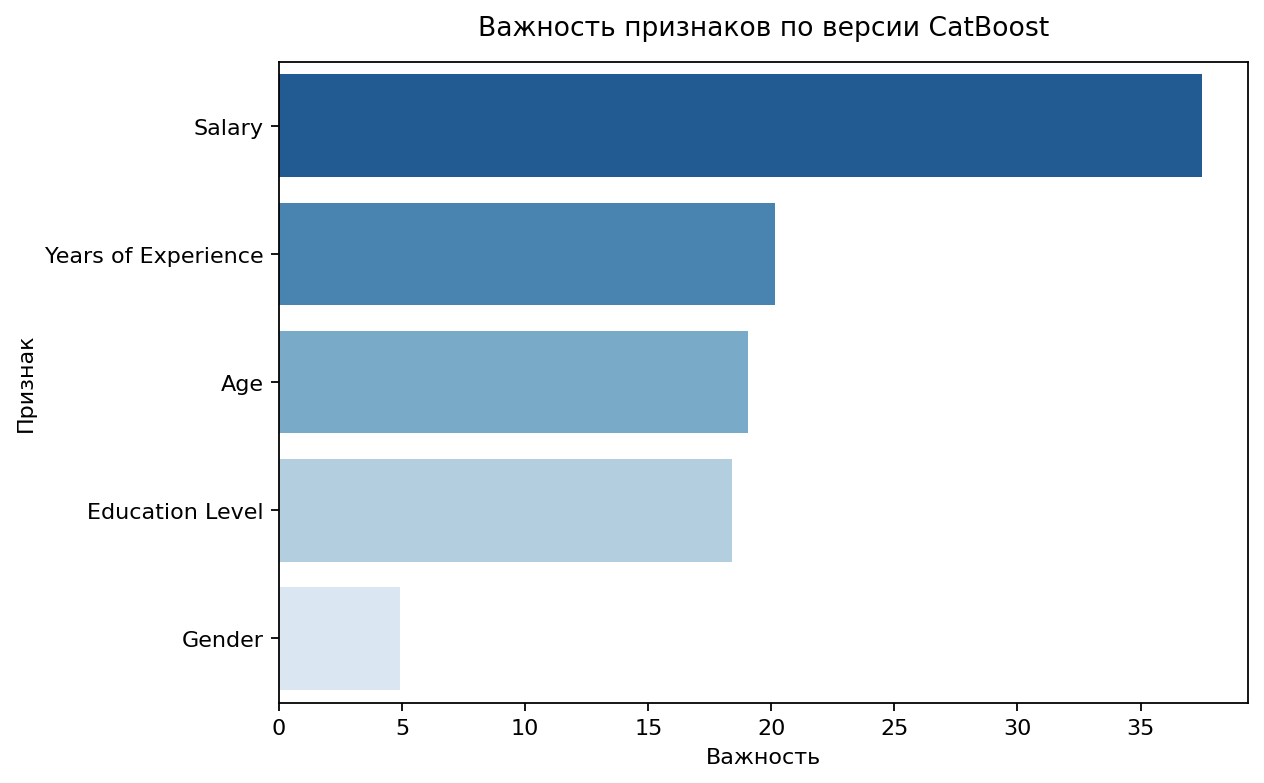

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = cat_model.get_feature_importance(prettified=True)

print("\n=== Важность признаков ===")
print(importances)

# Сортировка для красоты
importances = importances.sort_values(by="Importances", ascending=False)

plt.figure(figsize=(8,5), dpi=160)
sns.barplot(
    data=importances,
    x="Importances",
    y="Feature Id",
    palette="Blues_r"
)
plt.title("Важность признаков по версии CatBoost", fontsize=12, pad=12)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


Using Colab cache for faster access to the 'salary-data' dataset.


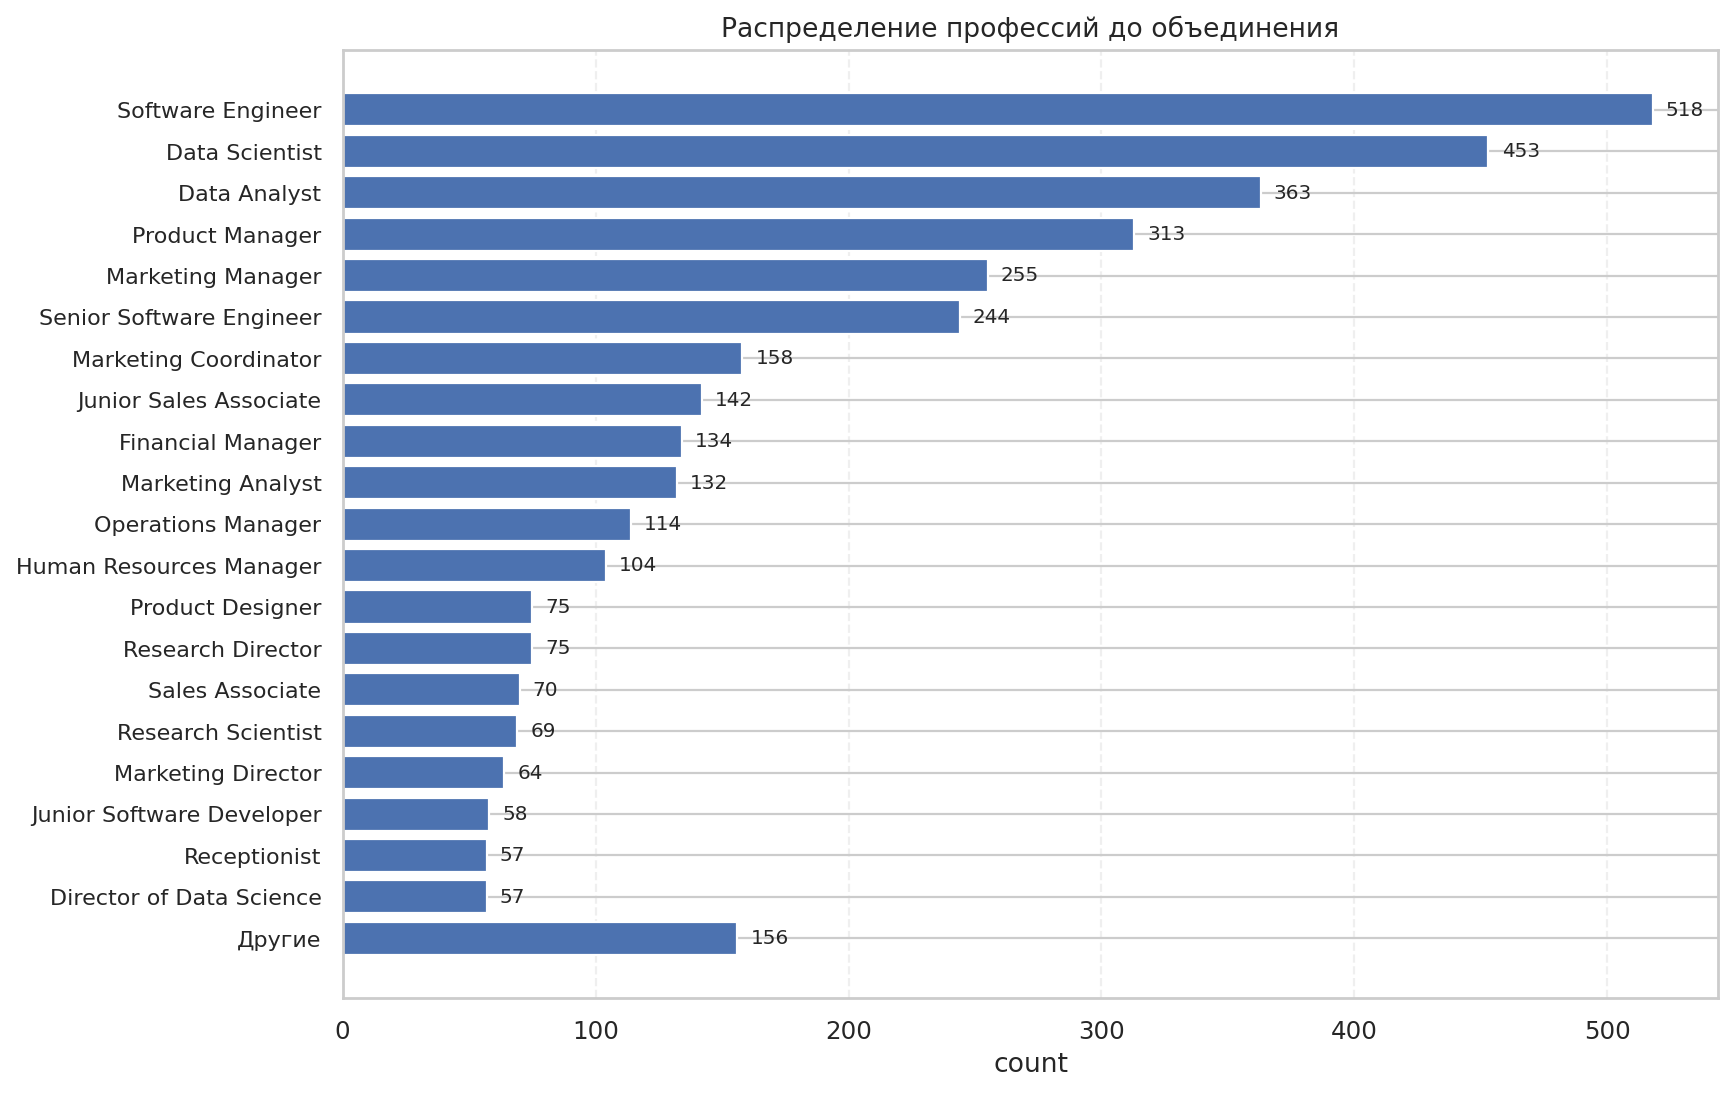

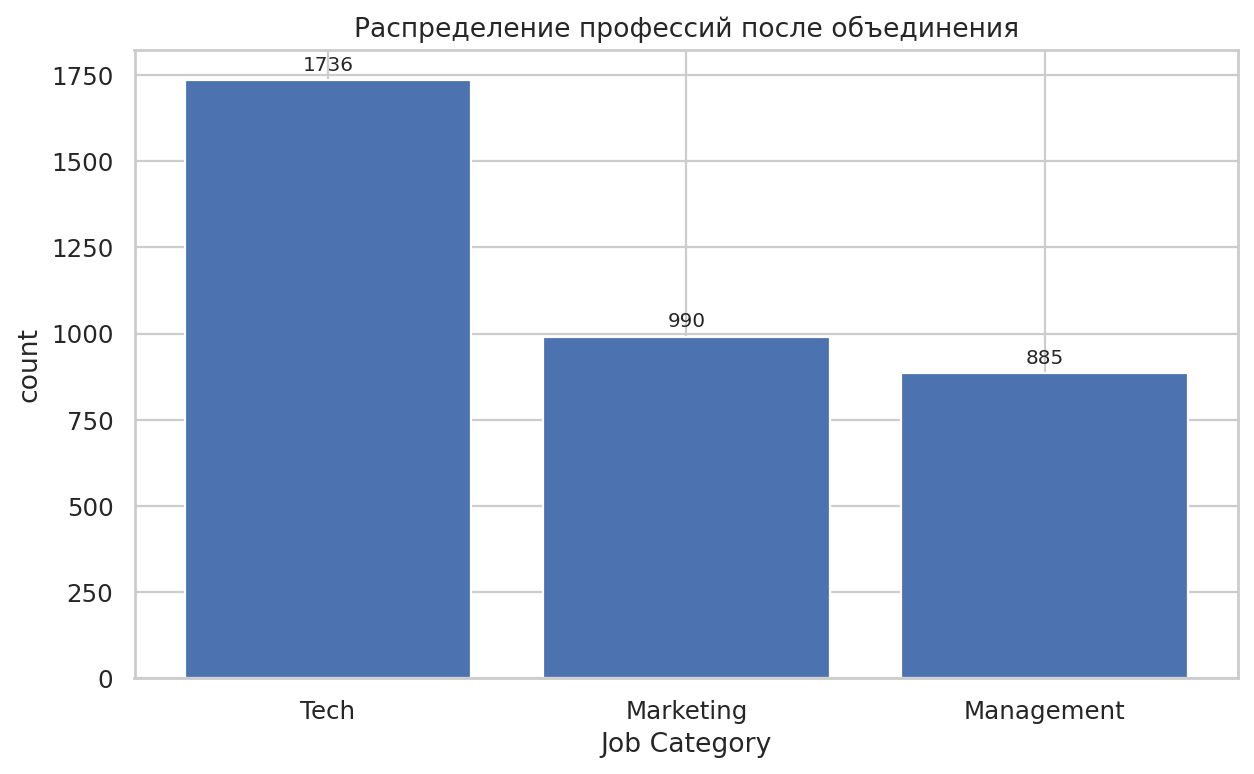


=== Сценарий A_no_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience'] ===

Сводка метрик:
       Model  Accuracy  Macro F1  Weighted F1  Macro ROC-AUC
       Dummy    0.4806    0.2164       0.3120         0.5000
RandomForest    0.8865    0.8812       0.8876         0.9185
    CatBoost    0.8644    0.8591       0.8658         0.9017


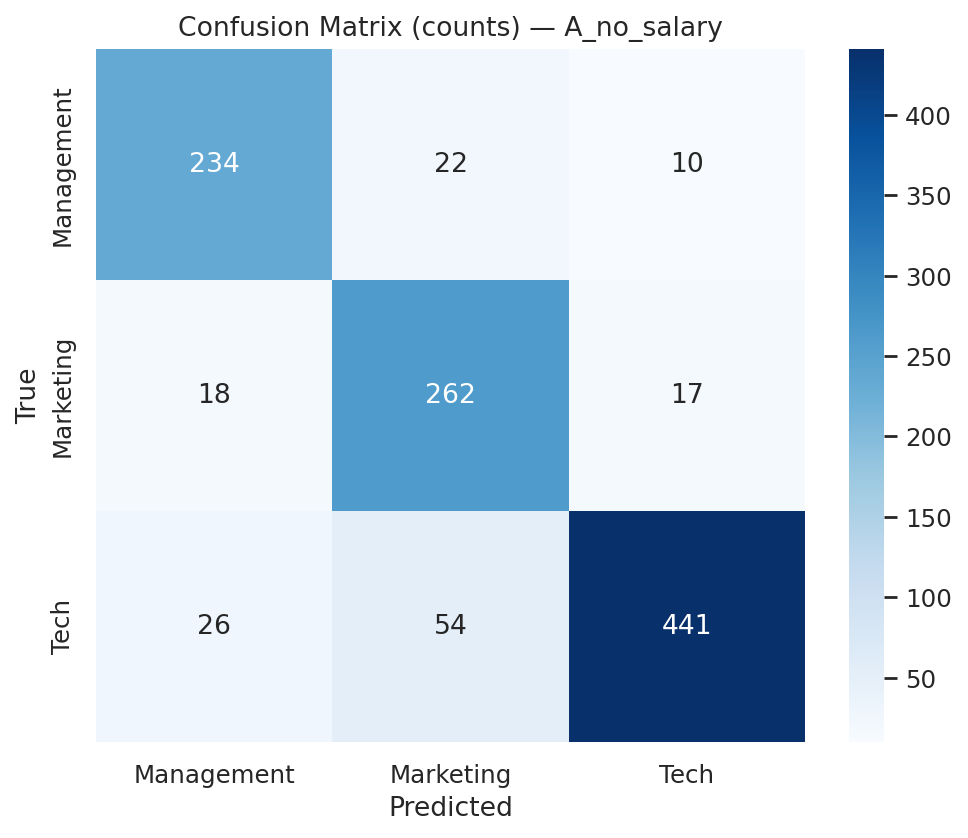

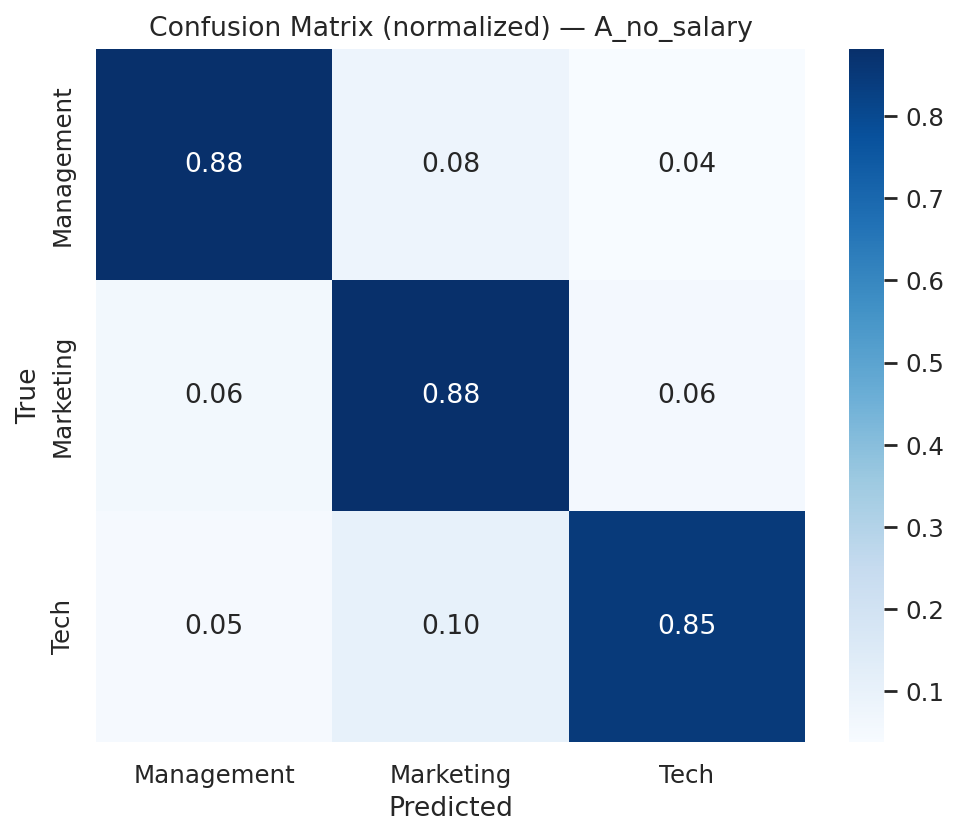

/tmp/ipython-input-2841736903.py:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp, x="Importances", y="Feature Id", palette="Blues_r")


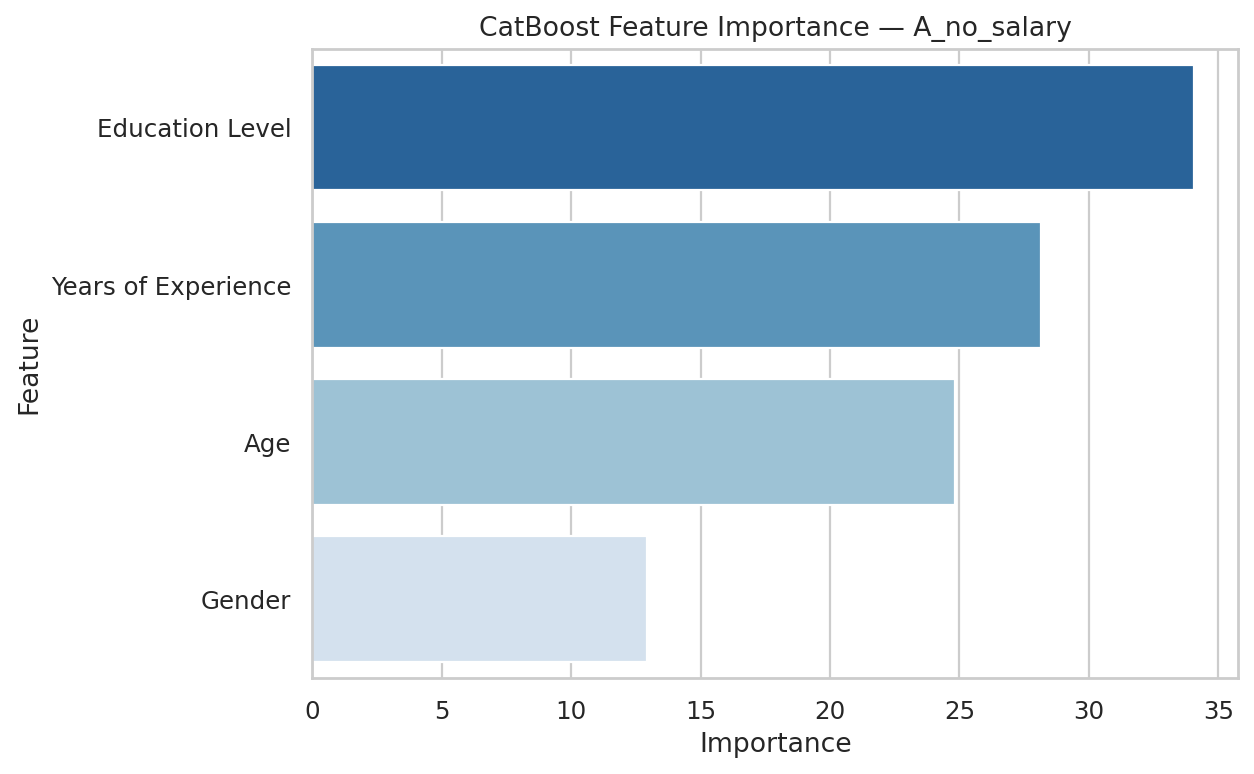


=== Сценарий B_with_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience', 'Salary'] ===

Сводка метрик:
       Model  Accuracy  Macro F1  Weighted F1  Macro ROC-AUC
       Dummy    0.4806    0.2164       0.3120         0.5000
RandomForest    0.9493    0.9467       0.9494         0.9626
    CatBoost    0.9391    0.9352       0.9393         0.9545


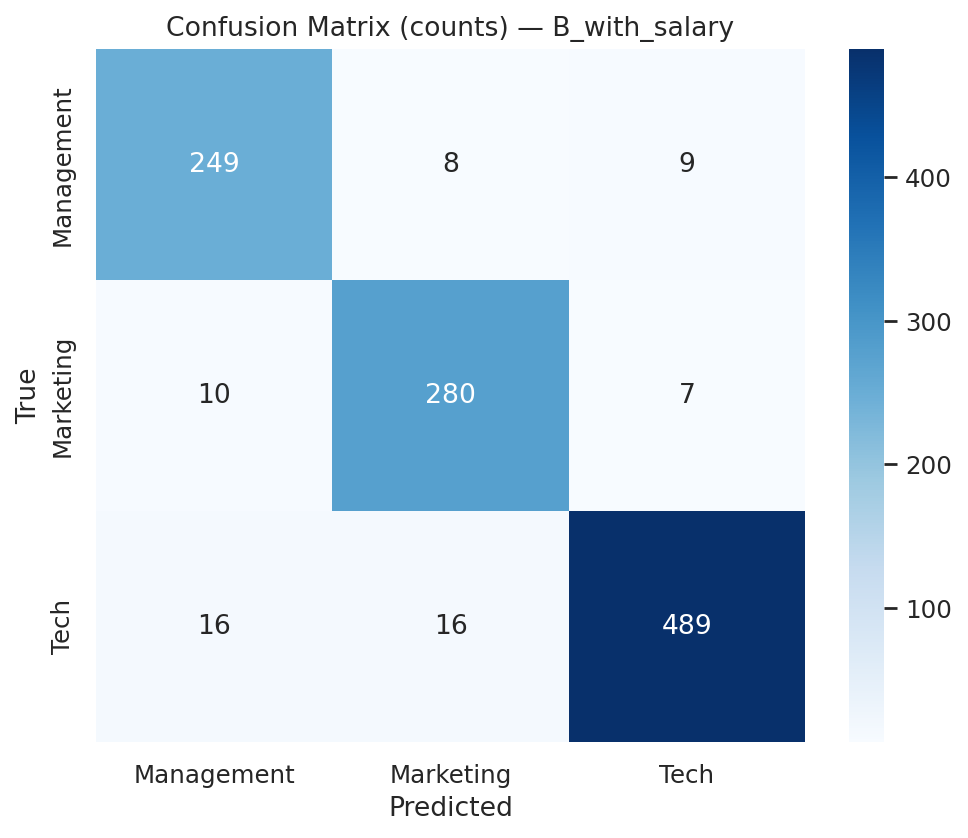

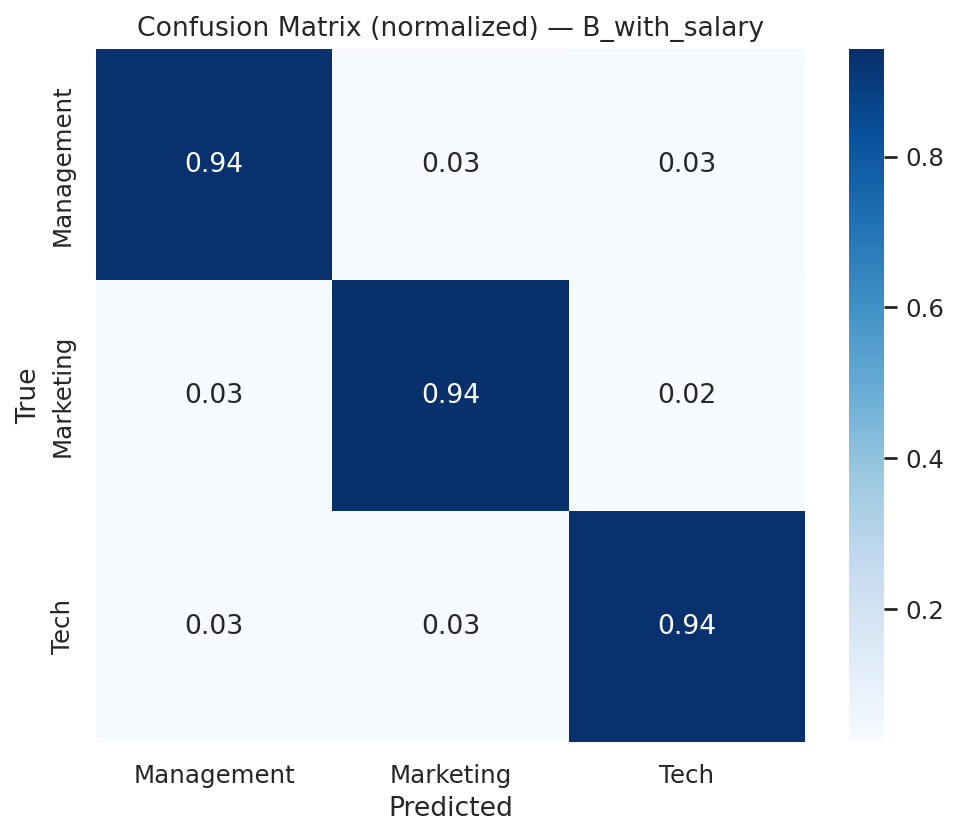

/tmp/ipython-input-2841736903.py:212: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp, x="Importances", y="Feature Id", palette="Blues_r")


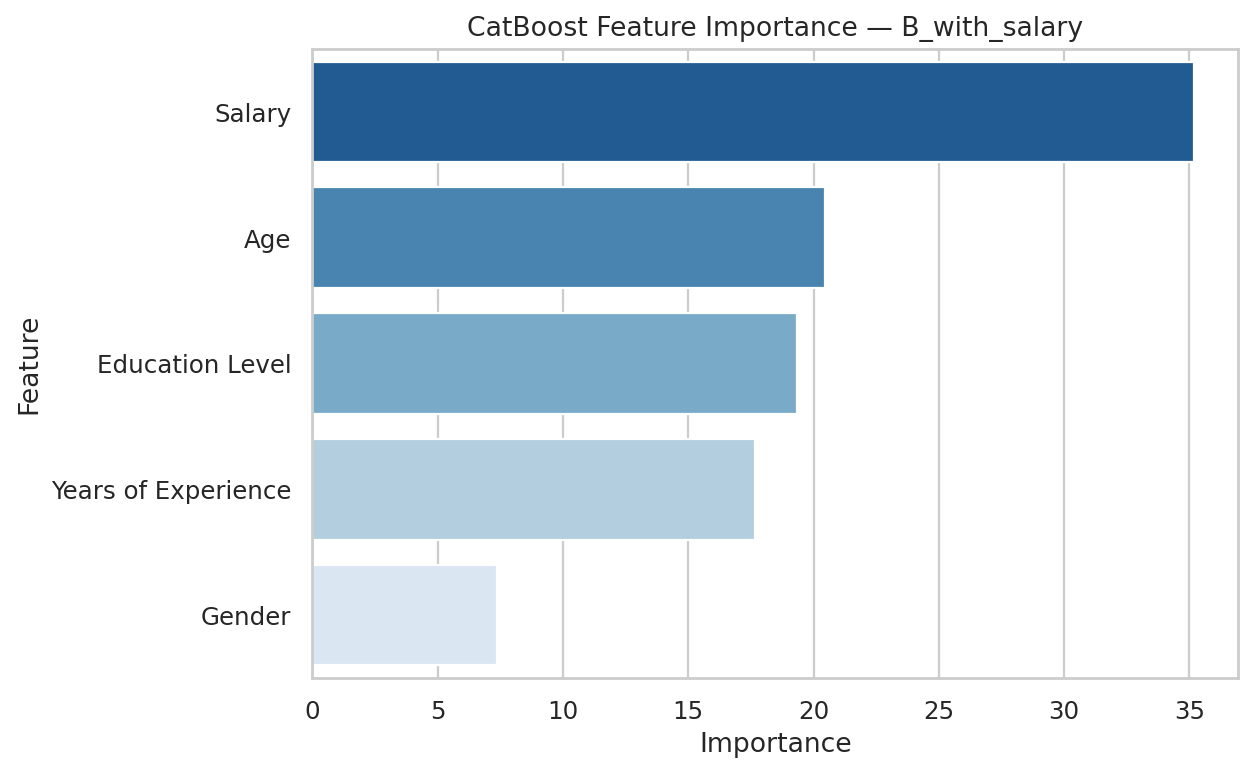


=== Итоги по двум сценариям ===
Setting       A_no_salary  B_with_salary
Model                                   
CatBoost           0.8591         0.9352
Dummy              0.2164         0.2164
RandomForest       0.8812         0.9467


In [ ]:
# ============ 0) Импорт и каталоги ============
import os
from pathlib import Path
from textwrap import shorten

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import kagglehub

sns.set(style="whitegrid")
ROOT = Path().resolve()
FIG_DIR = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

# ============ 1) Данные ============
path = kagglehub.dataset_download("mohithsairamreddy/salary-data")
csv_path = os.path.join(path, "Salary_Data.csv")
data = pd.read_csv(csv_path)

# базовая чистка
data = (data
        .dropna(subset=["Job Title"])
        .dropna()
        .copy())

# ============ 2) Агрегация профессий ============
job_map = {
    # Tech
    'Software Engineer':'Tech','Senior Software Engineer':'Tech','Junior Software Developer':'Tech',
    'Front End Developer':'Tech','Data Scientist':'Tech','Data Analyst':'Tech',
    'Machine Learning Engineer':'Tech','Machine Learning Scientist':'Tech','Data Specialist':'Tech',
    'Analytics Engineer':'Tech','Data Science Consultant':'Tech','Research Scientist':'Tech',
    # Management
    'Senior Manager':'Management','Project Manager':'Management','Product Manager':'Management',
    'Director of Data Science':'Management','Research Director':'Management','Operations Manager':'Management',
    'Human Resources Manager':'Management','Marketing Director':'Management','Financial Manager':'Management',
    # Marketing / Sales / Design / Support (в один блок)
    'Marketing Coordinator':'Marketing','Marketing Analyst':'Marketing','Marketing Manager':'Marketing',
    'Digital Marketing Specialist':'Marketing','Sales Associate':'Marketing','Junior Sales Associate':'Marketing',
    'Social Media Manager':'Marketing','Product Designer':'Marketing','Graphic Designer':'Marketing',
    'Receptionist':'Marketing','Customer Service Representative':'Marketing','Delivery Driver':'Marketing',
    'HR Specialist':'Marketing','Financial Analyst':'Marketing'
}
data["Job Category"] = data["Job Title"].map(job_map)
data = data.dropna(subset=["Job Category"]).copy()

# ---- красивый топ профессий ДО объединения
top_n = 20
counts = data["Job Title"].str.strip().value_counts()
top = counts.head(top_n)
other = counts.iloc[top_n:].sum()
if other > 0:
    top = pd.concat([top, pd.Series({"Другие": other})])
labels = [shorten(s, width=40, placeholder="…") for s in top.index]
vals = top.values
ypos = np.arange(len(vals))[::-1]

plt.figure(figsize=(11, 7), dpi=160)
plt.barh(ypos, vals)
plt.yticks(ypos, labels, fontsize=10)
plt.xlabel("count")
plt.title("Распределение профессий до объединения")
plt.grid(axis="x", ls="--", alpha=.3)
for y, v in zip(ypos, vals):
    plt.text(v + max(vals)*0.01, y, str(v), va="center", fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / "cls_jobs_before_merge.png", dpi=160)
plt.show()

# ---- после объединения
cat_counts = data["Job Category"].value_counts()
plt.figure(figsize=(8, 5), dpi=160)
order = cat_counts.index
plt.bar(order, cat_counts.values)
plt.ylabel("count"); plt.xlabel("Job Category")
plt.title("Распределение профессий после объединения")
for x, v in zip(order, cat_counts.values):
    plt.text(x, v + cat_counts.max()*0.01, str(v), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / "cls_jobs_after_merge.png", dpi=160)
plt.show()

# ============ 3) Две постановки задачи ============
# A) Реалистично: без Salary
feat_A = ["Age", "Gender", "Education Level", "Years of Experience"]
# B) Диагностически: c Salary
feat_B = feat_A + ["Salary"]
target = "Job Category"

# ======= вспомогательные =======
def macro_auc(y_true, y_pred_labels, labels):
    lb = LabelBinarizer().fit(labels)
    y_true_bin = lb.transform(y_true)
    y_pred_bin = lb.transform(y_pred_labels)
    try:
        return roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
    except Exception:
        return np.nan

def plot_cm(y_true, y_pred, labels, normalize, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=labels,
                          normalize=("true" if normalize else None))
    plt.figure(figsize=(6.4, 5.4), dpi=160)
    ax = sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                     cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=160)
    plt.show()

# ============ 4) Тренировка и оценка ============
def train_eval_block(X_cols, tag):
    print(f"\n=== Сценарий {tag}: признаки = {X_cols} ===")

    X = data[X_cols].copy()
    y = data[target].copy()

    # сплит со стратификацией
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
    )

    # заполнение пропусков
    num_fill = ["Age", "Years of Experience"] + (["Salary"] if "Salary" in X_cols else [])
    for col in num_fill:
        med = X_train[col].median()
        X_train.loc[:, col] = X_train[col].fillna(med)
        X_test.loc[:, col] = X_test[col].fillna(med)

    for col in ["Gender", "Education Level"]:
        if col in X_cols:
            X_train.loc[:, col] = X_train[col].fillna("Unknown")
            X_test.loc[:, col] = X_test[col].fillna("Unknown")

    labels = sorted(y.unique())

    # --- 0) Бэйзлайн
    dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
    dummy.fit(X_train, y_train)
    y_pred_d = dummy.predict(X_test)

    # --- 1) RandomForest с One-Hot (строки -> числа)
    cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
    X_train_rf = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
    X_test_rf = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
    # выравниваем колонки
    X_test_rf = X_test_rf.reindex(columns=X_train_rf.columns, fill_value=0)

    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf.fit(X_train_rf, y_train)
    y_pred_rf = rf.predict(X_test_rf)

    # --- 2) CatBoost (нативные категориальные)
    cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
    cb = CatBoostClassifier(
        iterations=600,
        depth=5,
        learning_rate=0.09,
        l2_leaf_reg=3.0,
        loss_function="MultiClass",
        random_state=RANDOM_STATE,
        verbose=0
    )
    cb.fit(X_train, y_train, cat_features=cat_idx)
    y_pred_cb = cb.predict(X_test)

    # --- сводка метрик
    rows = []
    for name, y_hat in [("Dummy", y_pred_d), ("RandomForest", y_pred_rf), ("CatBoost", y_pred_cb)]:
        report = classification_report(y_test, y_hat, output_dict=True, zero_division=0)
        rows.append({
            "Model": name,
            "Accuracy": report["accuracy"],
            "Macro F1": report["macro avg"]["f1-score"],
            "Weighted F1": report["weighted avg"]["f1-score"],
            "Macro ROC-AUC": macro_auc(y_test, y_hat, labels),
        })
    res = pd.DataFrame(rows).round(4)
    print("\nСводка метрик:")
    print(res.to_string(index=False))
    res.to_csv(ROOT / f"class_results_{tag}.csv", index=False)

    # --- матрицы ошибок (CatBoost)
    plot_cm(y_test, y_pred_cb, labels, normalize=False,
            title=f"Confusion Matrix (counts) — {tag}",
            fname=f"cm_counts_cb_{tag}.png")
    plot_cm(y_test, y_pred_cb, labels, normalize=True,
            title=f"Confusion Matrix (normalized) — {tag}",
            fname=f"cm_norm_cb_{tag}.png")

    # --- важности CatBoost
    imp = cb.get_feature_importance(prettified=True).sort_values("Importances", ascending=False)
    plt.figure(figsize=(8, 5), dpi=160)
    sns.barplot(data=imp, x="Importances", y="Feature Id", palette="Blues_r")
    plt.title(f"CatBoost Feature Importance — {tag}")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"cb_importance_{tag}.png", dpi=160)
    plt.show()

    return res

# Запуск двух сценариев
res_A = train_eval_block(feat_A, tag="A_no_salary")
res_B = train_eval_block(feat_B, tag="B_with_salary")

print("\n=== Итоги по двум сценариям ===")
both = pd.concat(
    [res_A.assign(Setting="A_no_salary"), res_B.assign(Setting="B_with_salary")],
    ignore_index=True
)
print(both.pivot(index="Model", columns="Setting", values="Macro F1").round(4))
both.to_csv(ROOT / "class_results_both.csv", index=False)


In [ ]:
plt.figure(figsize=(11,7), dpi=160)
plt.barh(ypos, vals)
plt.yticks(ypos, labels, fontsize=10)
plt.xlabel("count"); plt.title("Распределение профессий до объединения")
plt.grid(axis="x", ls="--", alpha=.3)
for y, v in zip(ypos, vals):
    plt.text(v + max(vals)*0.01, y, str(v), va="center", fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / "cls_jobs_before_merge.png", dpi=160)
plt.close()


In [ ]:
plt.figure(figsize=(8,5), dpi=160)
order = cat_counts.index
plt.bar(order, cat_counts.values)
plt.ylabel("count"); plt.xlabel("Job Category")
plt.title("Распределение профессий после объединения")
for x, v in zip(order, cat_counts.values):
    plt.text(x, v + cat_counts.max()*0.01, str(v), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(FIG_DIR / "cls_jobs_after_merge.png", dpi=160)
plt.close()


In [ ]:
def plot_cm(y_true, y_pred, labels, tag, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=labels,
                          normalize="true" if normalize else None)
    plt.figure(figsize=(6.4,5.4), dpi=160)
    ax = sns.heatmap(cm, annot=True,
                     fmt=".2f" if normalize else "d",
                     cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix ({'normalized' if normalize else 'counts'}) — {tag}")
    plt.tight_layout()
    fname = f"cm_{'norm' if normalize else 'counts'}_{tag}.png"
    plt.savefig(FIG_DIR / fname, dpi=160)
    plt.close()


In [ ]:
def train_eval_block(X_cols, tag):
    print(f"\n=== Сценарий {tag}: признаки = {X_cols} ===")
    X = data[X_cols].copy()
    y = data[target].copy()

    # сплит со стратификацией
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
    )

    # заполнение пропусков
    for col in ["Age","Years of Experience"] + (["Salary"] if "Salary" in X_cols else []):
        med = X_train[col].median()
        X_train.loc[:, col] = X_train[col].fillna(med)
        X_test.loc[:, col]  = X_test[col].fillna(med)
    for col in ["Gender","Education Level"]:
        if col in X_cols:
            X_train.loc[:, col] = X_train[col].fillna("Unknown")
            X_test.loc[:, col]  = X_test[col].fillna("Unknown")

    # CatBoost (главная модель)
    cat_features = [i for i,c in enumerate(X_train.columns) if X_train[c].dtype == "object"]
    cb = CatBoostClassifier(
        iterations=600, depth=5, learning_rate=0.09, l2_leaf_reg=3.0,
        loss_function="MultiClass", random_state=RANDOM_STATE, verbose=0
    )
    cb.fit(X_train, y_train, cat_features=cat_features)
    y_pred_cb = cb.predict(X_test)

    # метрики
    report = classification_report(y_test, y_pred_cb, output_dict=True, zero_division=0)
    res = pd.DataFrame([{
        "Model": "CatBoost",
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
    }]).round(4)

    return res, y_test, y_pred_cb


In [ ]:
res_A, y_test_A, y_pred_cb_A = train_eval_block(feat_A, tag="A_no_salary")
res_B, y_test_B, y_pred_cb_B = train_eval_block(feat_B, tag="B_with_salary")



=== Сценарий A_no_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience'] ===

=== Сценарий B_with_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience', 'Salary'] ===


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_two_confusion_matrices(y_test_A, y_pred_A, y_test_B, y_pred_B, labels, fname="cm_compare.png"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=160)

    # --- A_no_salary ---
    cm_A = confusion_matrix(y_test_A, y_pred_A, labels=labels, normalize="true")
    sns.heatmap(cm_A, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Confusion Matrix (normalized) — A_no_salary")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # --- B_with_salary ---
    cm_B = confusion_matrix(y_test_B, y_pred_B, labels=labels, normalize="true")
    sns.heatmap(cm_B, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title("Confusion Matrix (normalized) — B_with_salary")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=160)
    plt.show()


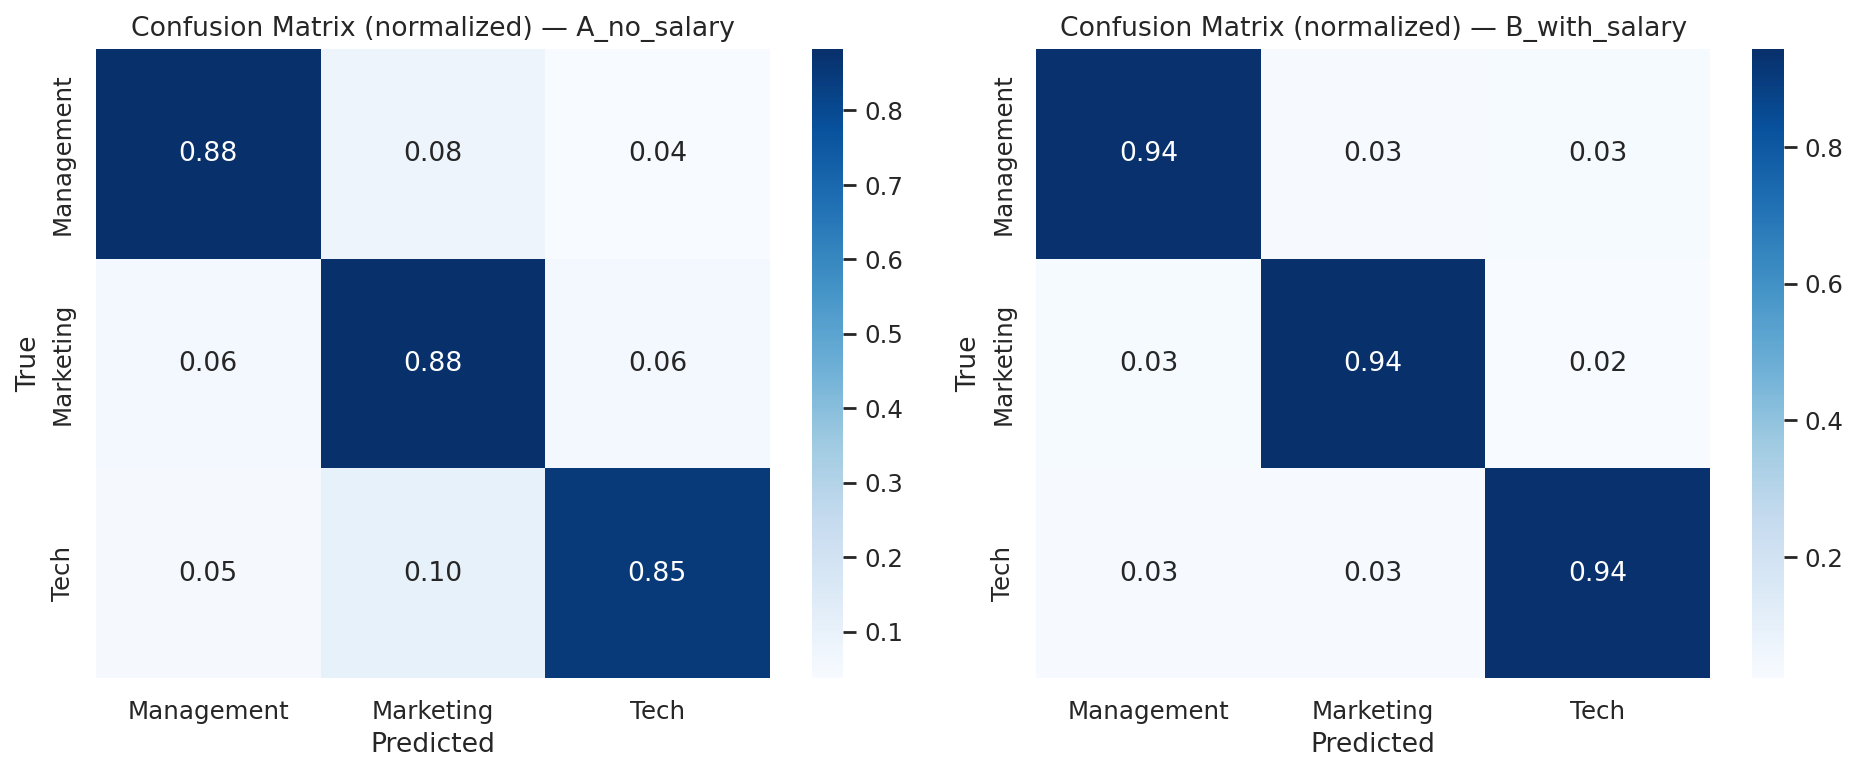

In [ ]:
plot_two_confusion_matrices(y_test_A, y_pred_cb_A,
                            y_test_B, y_pred_cb_B,
                            labels=sorted(data[target].unique()),
                            fname="cm_compare_A_vs_B.png")

In [ ]:
def train_eval_block(X_cols, tag):
    print(f"\n=== Сценарий {tag}: признаки = {X_cols} ===")
    X = data[X_cols].copy()
    y = data[target].copy()

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
    )

    # fillna
    for col in ["Age","Years of Experience"] + (["Salary"] if "Salary" in X_cols else []):
        med = X_train[col].median()
        X_train.loc[:, col] = X_train[col].fillna(med)
        X_test.loc[:, col]  = X_test[col].fillna(med)
    for col in ["Gender","Education Level"]:
        if col in X_cols:
            X_train.loc[:, col] = X_train[col].fillna("Unknown")
            X_test.loc[:, col]  = X_test[col].fillna("Unknown")

    # CatBoost
    cat_features = [i for i,c in enumerate(X_train.columns) if X_train[c].dtype == "object"]
    cb = CatBoostClassifier(
        iterations=600, depth=5, learning_rate=0.09, l2_leaf_reg=3.0,
        loss_function="MultiClass", random_state=RANDOM_STATE, verbose=0
    )
    cb.fit(X_train, y_train, cat_features=cat_features)
    y_pred_cb = cb.predict(X_test)

    # feature importance
    imp = cb.get_feature_importance(prettified=True).sort_values("Importances", ascending=False)

    return imp, y_test, y_pred_cb


In [ ]:
imp_A, y_test_A, y_pred_cb_A = train_eval_block(feat_A, tag="A_no_salary")
imp_B, y_test_B, y_pred_cb_B = train_eval_block(feat_B, tag="B_with_salary")



=== Сценарий A_no_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience'] ===

=== Сценарий B_with_salary: признаки = ['Age', 'Gender', 'Education Level', 'Years of Experience', 'Salary'] ===


/tmp/ipython-input-398414629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_A, x="Importances", y="Feature Id", ax=axes[0], palette="Blues_r")
/tmp/ipython-input-398414629.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_B, x="Importances", y="Feature Id", ax=axes[1], palette="Blues_r")


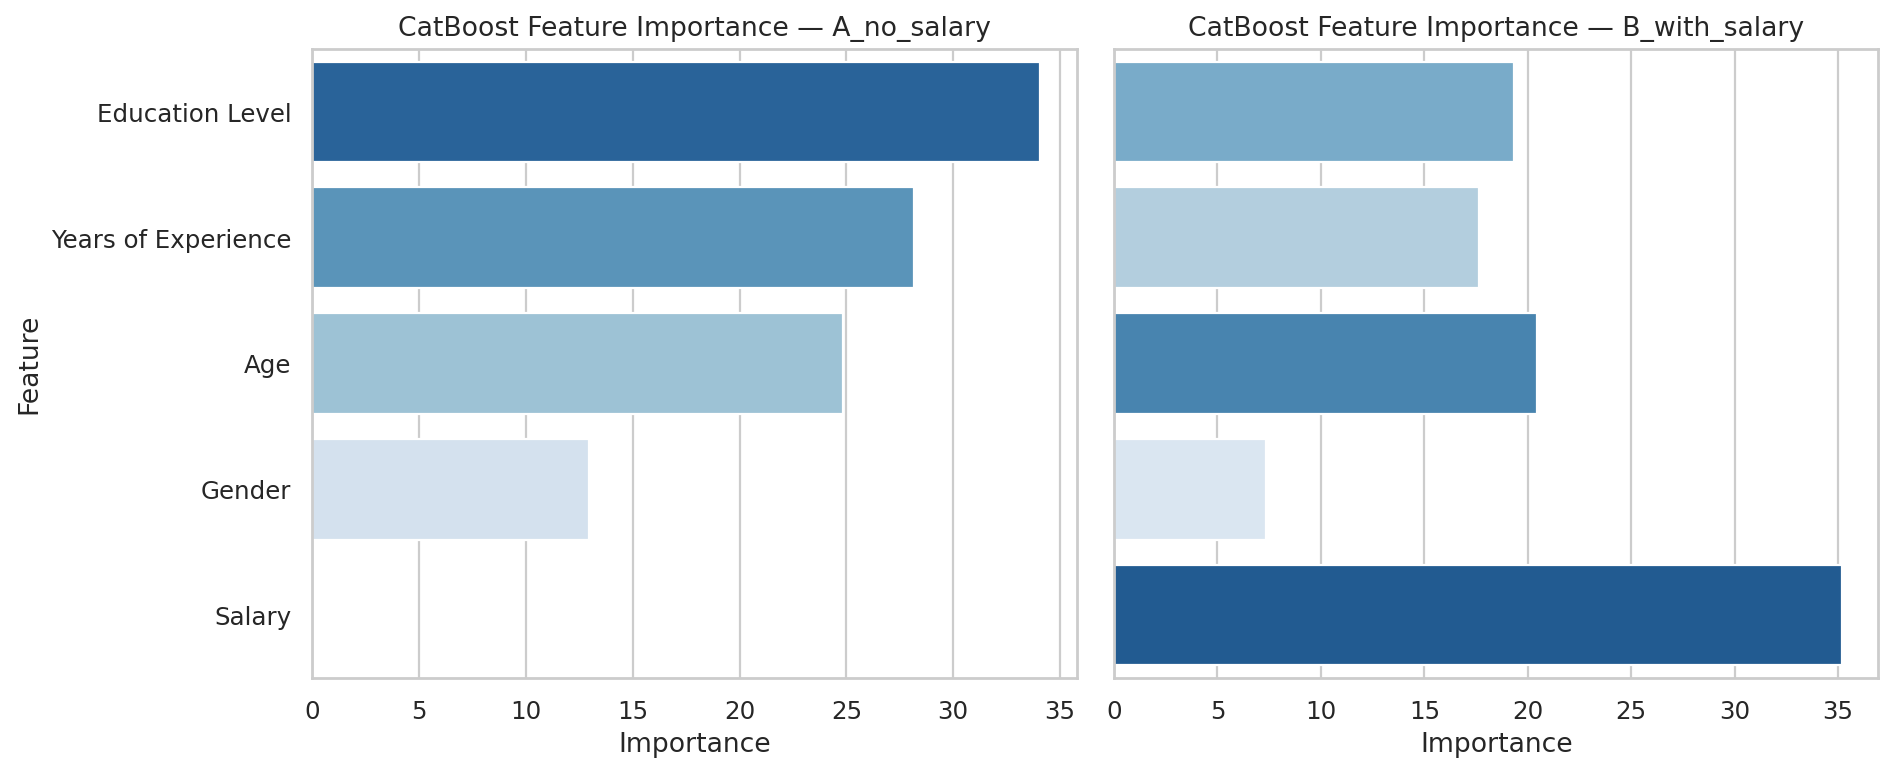

In [ ]:
plot_two_importances(imp_A, imp_B,
                     title_A="A_no_salary",
                     title_B="B_with_salary",
                     fname="cb_compare_importances.png")


/tmp/ipython-input-398414629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_A, x="Importances", y="Feature Id", ax=axes[0], palette="Blues_r")
/tmp/ipython-input-398414629.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_B, x="Importances", y="Feature Id", ax=axes[1], palette="Blues_r")


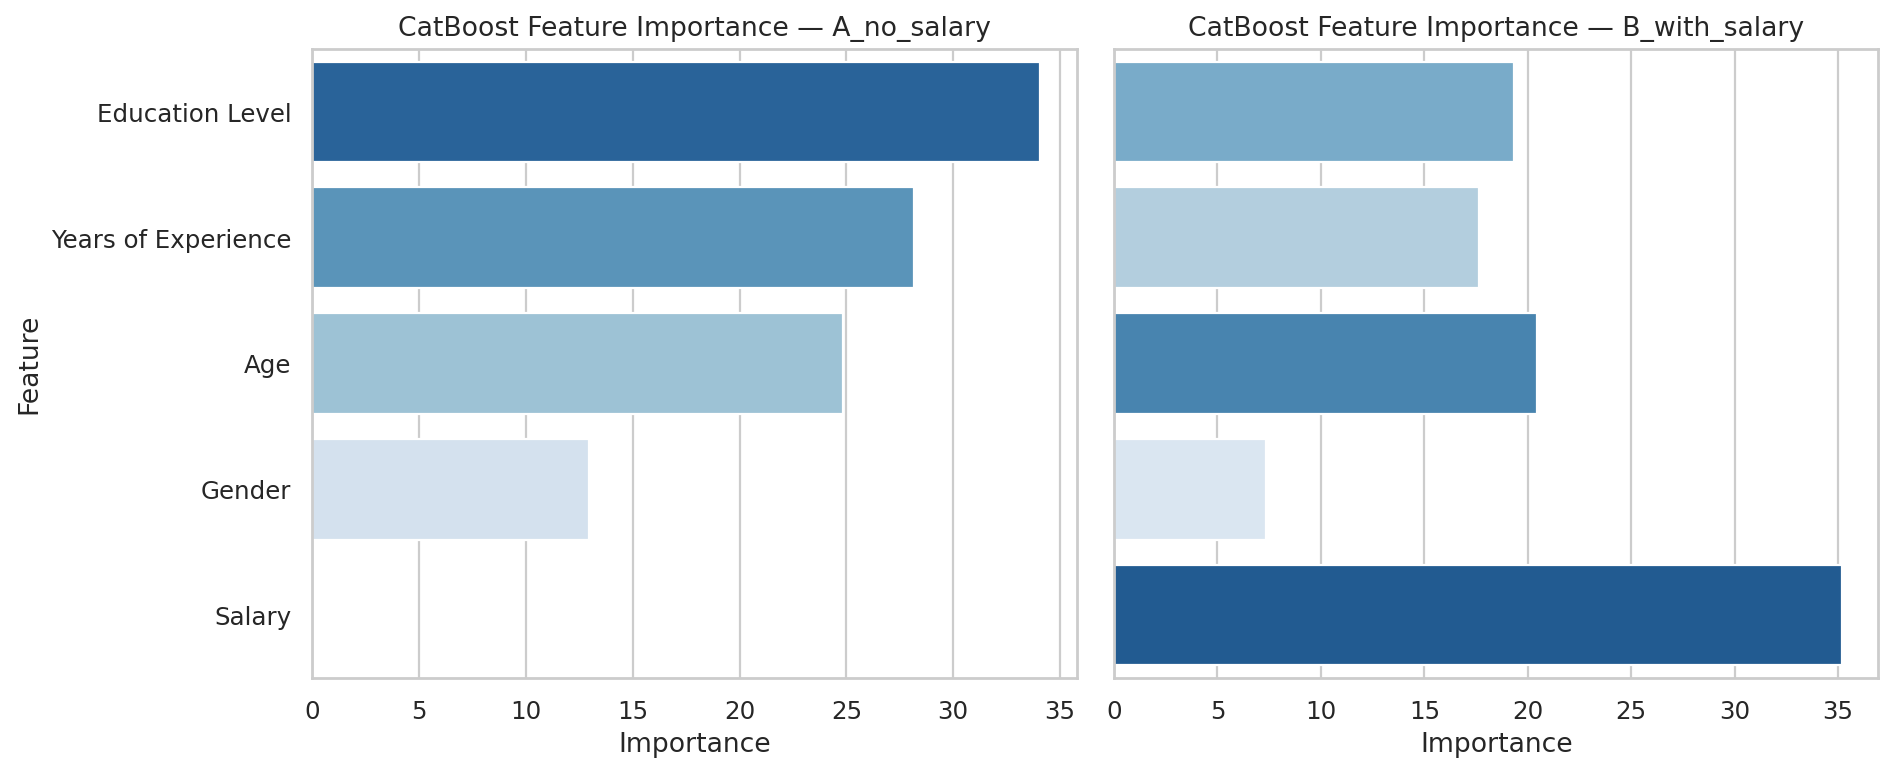

In [ ]:
plot_two_importances(imp_A, imp_B,
                     title_A="A_no_salary",
                     title_B="B_with_salary",
                     fname="cb_compare_importances.png")
